# Step 4 - Work on Speech

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import string
import sentencepiece as spm
from gensim.models.word2vec import Word2Vec
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

## Preprocessing the dataset

In [2]:
dataset = []

In [3]:
with open("data/quantized/LibriSpeech/train-full-960/quantized_outputs.txt") as input_file:
    for line in input_file.readlines():
        dataset.append(
            line.split("\t")[1].split(",")[1:]  # Exclude ID and get only data
        )

In [ ]:
# Assign a character to each number
letters = {
    i: key for i, key in enumerate(string.ascii_letters)
}

In [ ]:
# To make new char dataset from dataset
char_dataset = [
    [letters[int(v)] for v in line]
    for line in dataset
]

In [5]:
# Write new data to a file
char_dataset_filepath = "data/level_wise/level0/corpus_original.txt"

In [6]:
with open(char_dataset_filepath, "w+", encoding="utf-8") as char_ds_fp:
    for line in char_dataset:
        char_ds_fp.write("".join(line) + "\n")

In [6]:
# To load char dataset
char_dataset = []
with open(char_dataset_filepath, "r", encoding="utf-8") as char_ds_fp:
    for line in char_ds_fp.readlines():
        line = line.strip()
        char_dataset.append(list(line))

## Level 1

Convert sequence of pre-computed clusters into sequences

### Run SentencePiece on new dataset

In [7]:
input_file = char_dataset_filepath
sp_model_tag = "s4-lvl0"
max_sentence_length = 2000
vocab_size = 20000
model_type = "unigram"
SP_MODEL_NAME = f"models/{model_type}_vs{vocab_size}_{sp_model_tag}"

In [29]:
# train sentencepiece model from `botchan.txt` and makes `m.model` and `m.vocab`
# `m.vocab` is just a reference. not used in the segmentation.
spm.SentencePieceTrainer.train(
    f"--input={input_file} " \
    f"--model_type={model_type} " \
    f"--model_prefix={SP_MODEL_NAME} " \
    f"--vocab_size={vocab_size} " \
    f"--max_sentence_length={max_sentence_length} " \
    f"--train_extremely_large_corpus"
)

In [8]:
# Convert sentences to token sequences
sp_lvl0 = spm.SentencePieceProcessor()
sp_lvl0.load(f"{SP_MODEL_NAME}.model")

True

In [15]:
with open(input_file) as corpus_file:
    corpus = corpus_file.readlines()

sentences = [sp_lvl0.EncodeAsPieces(sentence)[1:] for sentence in corpus]

### Word2Vec

In [9]:
vector_size = 150
window = 1
w2v_model_tag = "s4-lvl0"
W2V_MODEL_PATH = f"models/w2v_vs{vector_size}_w{window}_{w2v_model_tag}.model"

In [101]:
w2v_lvl0 = Word2Vec(
    sentences,
    window=window,
    vector_size=vector_size,
    min_count=0,
    workers=4,
    epochs=7
)

In [102]:
w2v_lvl0.save(W2V_MODEL_PATH)

In [11]:
w2v_lvl0 = Word2Vec.load(W2V_MODEL_PATH)

#### Test optimal threshold for creating clusters

In [ ]:
n_clusters = []

for threshold in tqdm(range(0, 99, 1)):
    threshold = threshold / 100
    word_to_cluster = dict()  # Stores map from word to cluster
    cluster_to_words = dict()  # Stores map from cluster to words
    cluster_idx = 0  # Counter

    for word in words:
        # Check if word has already been clustered
        if word not in word_to_cluster.keys():
            # Create new cluster
            cluster_idx += 1
            cluster_key = chr(0x0020 + cluster_idx)

            # Add new word to cluster
            cluster_to_words[cluster_key] = [word]
            word_to_cluster[word] = cluster_key
            
            # Add all similar words
            for similar_word, score in model.wv.most_similar(word, topn=10000):
                if score > threshold:
                    cluster_to_words[cluster_key].append(similar_word)
                    word_to_cluster[similar_word] = cluster_key
    
    n_clusters.append(len(cluster_to_words))

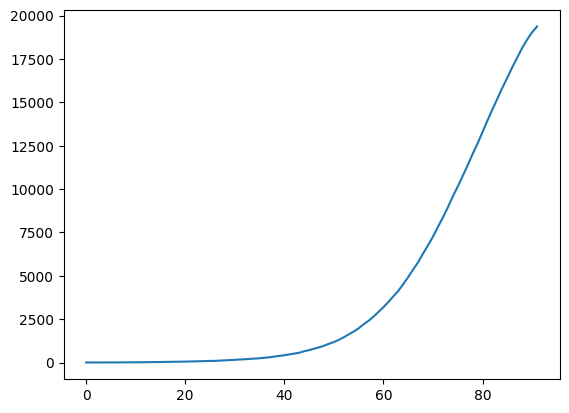

In [74]:
plt.plot(n_clusters)

### Create clusters

In [12]:
threshold = 0.55

words = list(w2v_lvl0.wv.key_to_index.keys())
word_to_cluster = dict()  # Stores map from word to cluster
cluster_to_words = dict()  # Stores map from cluster to words
cluster_idx = 0  # Counter

try:
    for word in words:
        # Check if word has already been clustered
        if word not in word_to_cluster.keys():
            # Create new cluster
            cluster_idx += 1
            while not chr(0x0020 + cluster_idx).isalpha() or not len(chr(0x0020 + cluster_idx)) == 1:
                cluster_idx += 1
            cluster_key = chr(0x0020 + cluster_idx)

            # Add new word to cluster
            cluster_to_words[cluster_key] = [word]
            word_to_cluster[word] = cluster_key
            
            # Add all similar words
            for similar_word, score in w2v_lvl0.wv.most_similar(word, topn=10000):
                if score > threshold:
                    cluster_to_words[cluster_key].append(similar_word)
                    word_to_cluster[similar_word] = cluster_key

except ValueError:
    print(len(cluster_to_words))

In [13]:
len(cluster_to_words)

1898

In [16]:
with open("data/lvl1_corpus.txt", "w+", encoding="utf-8") as lvl1_corpus_fp:
    for line in sentences:
        lvl1_corpus_fp.write("".join(word_to_cluster[piece] for piece in line) + "\n")

In [17]:
lvl1_utterances = {
    "librispeech": dict(),
    "synthetic": dict()
}

for dataset in ["librispeech", "synthetic"]:
    lvl1_utterances[dataset] = {}
    with open(f"data/quantized/semantic/dev/{dataset}/quantized_outputs.txt", "r") as utterance_file:
        for line in utterance_file.readlines():
            key, seq = line.strip().split("\t")
            utterance = seq.split(",")[1:]
            lvl0_utterance = "".join(
                [letters[int(v)] for i, v in enumerate(utterance) if i == 0 or v != utterance[i - 1]]
            )

            lvl1_utterances[dataset][key] = "".join(word_to_cluster[piece] for piece in sp_lvl0.EncodeAsPieces(lvl0_utterance)[1:])

In [18]:
input_file = "data/lvl1_corpus.txt"
sp_model_tag = "s4-lvl1"
max_sentence_length = 2000
vocab_size = 20000
model_type = "unigram"
SP_MODEL_NAME = f"models/{model_type}_vs{vocab_size}_{sp_model_tag}"

In [19]:
# train sentencepiece model from `botchan.txt` and makes `m.model` and `m.vocab`
# `m.vocab` is just a reference. not used in the segmentation.
spm.SentencePieceTrainer.train(
    f"--input={input_file} " \
    f"--model_type={model_type} " \
    f"--model_prefix={SP_MODEL_NAME} " \
    f"--vocab_size={vocab_size} " \
    f"--max_sentence_length={max_sentence_length} " \
    f"--train_extremely_large_corpus"
)

In [20]:
# Convert sentences to token sequences
sp_lvl1 = spm.SentencePieceProcessor()
sp_lvl1.load(f"{SP_MODEL_NAME}.model")

True

In [89]:
with open(input_file, encoding="utf-8") as corpus_file:
    corpus = corpus_file.readlines()

sentences = []
for sentence in corpus:
    pieces = sp_lvl1.EncodeAsPieces(sentence)
    if pieces[0] == "_":
        sentences.append(pieces[1:])
    else:
        new_pieces = [pieces[0][1:]]
        new_pieces.extend(pieces[1:])
        sentences.append(new_pieces)

In [90]:
vector_size = 150
window = 5
w2v_model_tag = "s4-lvl1"
W2V_MODEL_PATH = f"models/w2v_vs{vector_size}_w{window}_{w2v_model_tag}.model"

In [91]:
w2v_lvl1 = Word2Vec(
    sentences,
    window=window,
    vector_size=vector_size,
    min_count=0,
    workers=4,
    epochs=7
)

In [92]:
w2v_lvl1.save(W2V_MODEL_PATH)

In [93]:
w2v_lvl1 = Word2Vec.load(W2V_MODEL_PATH)

## Testing

In [94]:
word_to_key = {}
key_to_word = {}

with open("data/quantized/dev-gold.csv", "r") as key_file:
    for line in key_file.readlines()[1:]:
        dataset, key, _, word = line.strip().split(",")
        if word not in word_to_key:
            word_to_key[word] = {
                'librispeech': [],
                'synthetic': []
            }
        word_to_key[word][dataset].append(key)
        key_to_word[key] = word

In [95]:
sim_pairs = []
rel_pairs = []

with open("data/quantized/dev-pairs.csv", "r") as pairs_file:
    for line in pairs_file.readlines()[1:]:
        dataset, _, w1, w2, sim, rel = line.strip().split(",")
        if sim:
            sim_pairs.append((dataset, w1, w2, float(sim)))
        if rel:
            rel_pairs.append((dataset, w1, w2, float(rel)))

In [96]:
# all_utterances = {
#     "librispeech": dict(),
#     "synthetic": dict()
# }

# for dataset in ["librispeech", "synthetic"]:
#     all_utterances[dataset] = {}
#     with open(f"data/quantized/semantic/dev/{dataset}/quantized_outputs.txt", "r") as utterance_file:
#         for line in utterance_file.readlines():
#             key, seq = line.strip().split("\t")
#             utterance = seq.split(",")[1:]

#             all_utterances[dataset][key] = "".join(
#                 [letters[int(v)] for i, v in enumerate(utterance) if i == 0 or v != utterance[i - 1]]
#             )

In [137]:
def get_vector_from_utterance(utterance, model):
    if utterance in model.wv.key_to_index.keys():
        return model.wv[utterance].reshape(1, -1)
    else:
        pieces = sp_lvl1.EncodeAsPieces(utterance)
        if pieces[0] == "_":
            units = pieces[1:]
        else:
            units = [pieces[0][1:]]
            units.extend(pieces[1:])
        if len(units) <= 1:
            print(units)
        vectors = np.array([model.wv[unit] for unit in units])
        return vectors.mean(axis=0).reshape(1, -1)

In [138]:
similarity_scores = {
    "librispeech": {
        "min": [],
        "max": [],
        "avg": []
    },
    "synthetic": {
        "min": [],
        "max": [],
        "avg": []
    }
}

rels = {
    "librispeech": [],
    "synthetic": []
}
total = 0
errors = 0

for pair in rel_pairs:
    dataset, w1, w2, rel = pair

    try:
        w1_utterances = [
            lvl1_utterances[dataset][key] for key in word_to_key[w1][dataset]
        ]
        w2_utterances = [
            lvl1_utterances[dataset][key] for key in word_to_key[w2][dataset]
        ]

        # try:
        w1_vectors = np.array(
            [get_vector_from_utterance(utt, w2v_lvl1) for utt in w1_utterances]
        )
        w2_vectors = np.array(
            [get_vector_from_utterance(utt, w2v_lvl1) for utt in w2_utterances]
        )
        # except:
        #     print([sp_lvl1.EncodeAsPieces(utt)[1:] for utt in w1_utterances])
        #     print([sp_lvl1.EncodeAsPieces(utt) for utt in w2_utterances])
            # units = sp_lvl1.EncodeAsPieces(w2_utterances[])[1:]
            # vectors = np.array([w2v_lvl1.wv[unit] for unit in units])
            # print(vectors.shape)
            # break

        similarities = [cosine_similarity(i, j) for i in w1_vectors for j in w2_vectors]

        similarity_scores[dataset]["min"].append(np.min(similarities))
        similarity_scores[dataset]["avg"].append(np.mean(similarities))
        similarity_scores[dataset]["max"].append(np.max(similarities))

        rels[dataset].append(rel)

    except KeyError:
        errors += 1
        continue

    total += 1

['dž']
['ਫ਼']
['ਫ਼']
['ɹ']


In [139]:
relation_scores = {
    dataset : {
        variant : pearsonr(similarity_scores[dataset][variant], rels[dataset])[0] * 100
        for variant in similarity_scores[dataset].keys()
    }
    for dataset in similarity_scores.keys()
}

In [140]:
relation_scores, errors, total

({'librispeech': {'min': 4.065779997417401,
   'max': 1.1216880597955048,
   'avg': 3.5743457130670246},
  'synthetic': {'min': 0.558107353760786,
   'max': 5.511183829212604,
   'avg': 1.8792798557574524}},
 4,
 1010)

In [141]:
def score_model(model):
    similarity_scores = {
        "librispeech": [],
        "synthetic": []
    }

    rels = {
        "librispeech": [],
        "synthetic": []
    }

    with open("results/complete_sim.csv", "w+") as sim_file:
        sim_file.write("dataset,w1,w2,gold_standard,model\n")
        for pair in rel_pairs:
            try:
                dataset, w1, w2, rel = pair
                w1_utterances = [
                    lvl1_utterances[dataset][key] for key in word_to_key[w1][dataset]
                ]
                w2_utterances = [
                    lvl1_utterances[dataset][key] for key in word_to_key[w2][dataset]
                ]

                w1_vectors = np.array(
                    [get_vector_from_utterance(utt, model) for utt in w1_utterances]
                )
                w2_vectors = np.array(
                    [get_vector_from_utterance(utt, model) for utt in w2_utterances]
                )

                for i in w1_vectors:
                    for j in w2_vectors:
                        similarity_scores[dataset].append(cosine_similarity(i, j).item())
                        rels[dataset].append(rel)
                
                        sim_file.write(",".join([dataset, w1, w2, str(rel), str(cosine_similarity(i, j).item())]) +"\n")
            except KeyError:
                continue
    
    relation_scores = {
        dataset : pearsonr(similarity_scores[dataset], rels[dataset])[0]
        for dataset in similarity_scores.keys()
    }

    return relation_scores["librispeech"] * 100, relation_scores["synthetic"] * 100

In [142]:
score_model(w2v_lvl1)

['dž']
['ਫ਼']
['ਫ਼']
['ɹ']


(-0.0753697231971494, 1.0729163991983643)

In [144]:
ls_scores = []
sy_scores = []

print("EPOCH 1")
test_model = Word2Vec(sentences, vector_size=vector_size, window=window, workers=4, min_count=0, epochs=1)
scores = score_model(test_model)
print(scores)

ls_scores.append(scores[0])
sy_scores.append(scores[1])

for i in range(50):
    print(f"EPOCH {i+1}")
    test_model.train(sentences, total_examples=test_model.corpus_count, epochs=1)

    scores = score_model(test_model)
    print(scores)

    ls_scores.append(scores[0])
    sy_scores.append(scores[1])

EPOCH 1
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(-1.0846426209664988, 0.6129611178255678)
EPOCH 1
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(-0.27159811875313633, 0.7863310395170279)
EPOCH 2
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(-0.307521303780927, 0.8983201235252628)
EPOCH 3
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(-0.32419691757046265, 1.3242038035390884)
EPOCH 4
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(-0.11691599769023382, 1.346267689783848)
EPOCH 5
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(-0.20667175262482898, 1.272622464201465)
EPOCH 6
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(0.3338101084831265, 1.205754417677398)
EPOCH 7
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(0.28800663492011375, 1.1911600688022683)
EPOCH 8
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(0.03090003970756048, 1.3237003710755983)
EPOCH 9
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(0.24610401585205216, 1.0858420566666274)
EPOCH 10
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(0.09404153996606066, 1.1524495309479765)
EPOCH 11
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(0.24453225810427498, 1.1165450057832034)
EPOCH 12
['dž']
['ਫ਼']
['ਫ਼']
['ɹ']
(0.21278242473338027, 1.031985813812834

KeyboardInterrupt: 

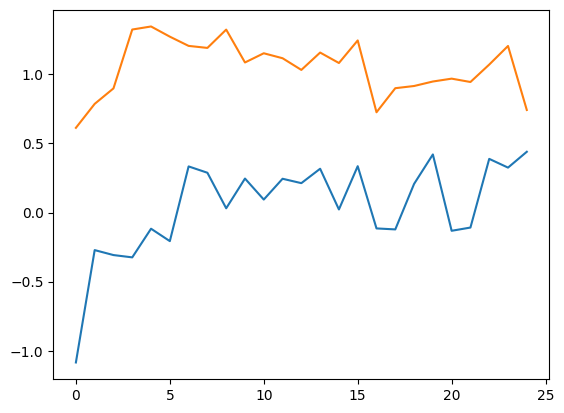

In [145]:
plt.plot(ls_scores)
plt.plot(sy_scores)